# Scanning Session Ingestion

## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()

from adamacs.pipeline import subject, session, surgery, scan, event, trial, imaging
from adamacs import utility
from adamacs.ingest import behavior as ibe
import numpy as np
import scanreader

[2023-01-16 18:53:42,494][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-01-16 18:53:42,554][INFO]: Connected tobiasr@172.26.128.53:3306


Manual entry:

In [ ]:
# Manual Entry
import datajoint as dj; import getpass
dj.config['database.host'] = '172.26.128.53'        # Put the server name between these apostrophe
dj.config['database.user'] = 'root'             # Put your user name between these apostrophe
dj.config['database.password'] = getpass.getpass()  # Put your password in the prompt
dj.conn()

from adamacs.pipeline import subject, session, surgery, scan, event, trial, imaging
from adamacs import utility
from adamacs.ingest import behavior as ibe
import numpy as np

## populate scaninfo

In [ ]:
scan.ScanInfo.describe()

In [2]:
scan.ScanInfo.heading

session_id           : varchar(12)                  # 
scan_id              : varchar(12)                  # 
---
nfields              : tinyint                      # number of fields
nchannels            : tinyint                      # number of channels
ndepths              : int                          # Number of scanning depths (planes)
nframes              : int                          # number of recorded frames
nrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)
x=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
y=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
z=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
fps                  : float                        # (Hz) frames per second - Volumetric Scan Rate
bidirectional        : tinyint        

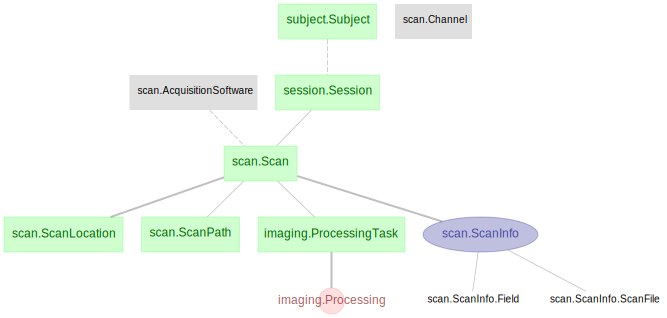

In [2]:
dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + dj.Diagram(scan) + dj.Diagram(imaging.Processing)

In [16]:
scan.ScanInfo.delete()
scan.Scan.delete()
session.Session.delete()

[2023-01-16 18:58:53,498][INFO]: Deleting 0 rows from `tobiasr01_scan`.`_scan_info`
[2023-01-16 18:58:53,539][INFO]: Deleting 1 rows from `tobiasr01_scan`.`scan_location`
[2023-01-16 18:58:53,562][INFO]: Deleting 1 rows from `tobiasr01_scan`.`scan_path`
[2023-01-16 18:58:53,575][INFO]: Deleting 1 rows from `tobiasr01_scan`.`scan`


Nothing to delete.


[2023-01-16 18:58:57,145][INFO]: Deleting 1 rows from `tobiasr01_session`.`project_session`
[2023-01-16 18:58:57,163][INFO]: Deleting 1 rows from `tobiasr01_session`.`session_directory`
[2023-01-16 18:58:57,190][INFO]: Deleting 1 rows from `tobiasr01_session`.`session_user`
[2023-01-16 18:58:57,210][INFO]: Deleting 1 rows from `tobiasr01_session`.`session`


Deletes committed.
Deletes committed.


1

In [25]:
scan.Scan()

session_id,scan_id,scanner,acq_software,scan_notes free-notes
sess9FG1TAXY,scan9FG1THFD,mini2p1,ScanImage,
sess9FG1UAQG,scan9FG1UAQG,mini2p1,ScanImage,


## populate scan!

In [18]:
populate_settings = {'display_progress': True}

In [29]:
scan.ScanInfo.populate(**populate_settings)
scan.ScanInfo()

ScanInfo:   0%|          | 0/1 [00:00<?, ?it/s]

<class 'list'> ['/Users/trose/Data/TR_ROS-1438_2023-01-13_scan9FG1UAQG_sess9FG1UAQG/scan9FG1UAQG_TR_ROS-1438_00006_00018.tif', '/Users/trose/Data/TR_ROS-1438_2023-01-13_scan9FG1UAQG_sess9FG1UAQG/scan9FG1UAQG_TR_ROS-1438_00006_00008.tif', '/Users/trose/Data/TR_ROS-1438_2023-01-13_scan9FG1UAQG_sess9FG1UAQG/scan9FG1UAQG_TR_ROS-1438_00006_00009.tif', '/Users/trose/Data/TR_ROS-1438_2023-01-13_scan9FG1UAQG_sess9FG1UAQG/scan9FG1UAQG_TR_ROS-1438_00006_00007.tif', '/Users/trose/Data/TR_ROS-1438_2023-01-13_scan9FG1UAQG_sess9FG1UAQG/scan9FG1UAQG_TR_ROS-1438_00006_00013.tif', '/Users/trose/Data/TR_ROS-1438_2023-01-13_scan9FG1UAQG_sess9FG1UAQG/scan9FG1UAQG_TR_ROS-1438_00006_00012.tif', '/Users/trose/Data/TR_ROS-1438_2023-01-13_scan9FG1UAQG_sess9FG1UAQG/scan9FG1UAQG_TR_ROS-1438_00006_00006.tif', '/Users/trose/Data/TR_ROS-1438_2023-01-13_scan9FG1UAQG_sess9FG1UAQG/scan9FG1UAQG_TR_ROS-1438_00006_00010.tif', '/Users/trose/Data/TR_ROS-1438_2023-01-13_scan9FG1UAQG_sess9FG1UAQG/scan9FG1UAQG_TR_ROS-1438_000

ScanInfo:   0%|          | 0/1 [00:00<?, ?it/s]


OperationalError: (1241, 'Operand should contain 1 column(s)')

In [ ]:
scan.ScanInfo()

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan
sess9FG1TAXY,scan9FG1THFD,1,2,1,1500,0,nan,nan,nan,15.3845,1,250.003,0.95,None,97.5007


: 

: 

In [ ]:
scan.Scan() * scan.ScanLocation()

: 

: 

Example to update an entry post-hoc. TODO: imnplement in elements "Scan" function based on userfunction stringa

In [ ]:
scan.Scan.update1({'session_id': 'sess9FF6TL96', 'scan_id': 'scan9FF6TL96', 'scan_notes': "test2"})

: 

: 

In [ ]:
scan.ScanLocation.update1({'session_id': 'sess9FF6TL96', 'scan_id': 'scan9FF6TL96', 'anatomical_location': "V1"})

: 

: 

In [ ]:
session.ProjectSession()

: 

: 

In [ ]:
scan.Scan()

: 

: 

In [ ]:
scan.ScanLocation()

: 

: 

### Creating a Parameter Set

What exactly happens during processing dependso on the parameter set. This is an example of a parameter set and its insert:

In [ ]:
# Insert the param_set

# TODO: Parameter set needs to be updated with ScanInfo settings

params_suite2p = {'look_one_level_down': 0.0,
                  'fast_disk': [],
                  'delete_bin': False,
                  'mesoscan': False,
                  'h5py': [],
                  'h5py_key': 'data',
                  'save_path0': [],
                  'subfolders': [],
                  'nplanes': 1,
                  'nchannels': 1,
                  'functional_chan': 1,
                  'tau': 1.0,
                  'fs': 10.0,
                  'force_sktiff': False,
                  'preclassify': 0.0,
                  'save_mat': False,
                  'combined': True,
                  'aspect': 1.0,
                  'do_bidiphase': False,
                  'bidiphase': 0.0,
                  'do_registration': True,
                  'keep_movie_raw': False,
                  'nimg_init': 300,
                  'batch_size': 500,
                  'maxregshift': 0.1,
                  'align_by_chan': 1,
                  'reg_tif': False,
                  'reg_tif_chan2': False,
                  'subpixel': 10,
                  'smooth_sigma': 1.15,
                  'th_badframes': 1.0,
                  'pad_fft': False,
                  'nonrigid': True,
                  'block_size': [128, 128],
                  'snr_thresh': 1.2,
                  'maxregshiftNR': 5.0,
                  '1Preg': False,
                  'spatial_hp': 50.0,
                  'pre_smooth': 2.0,
                  'spatial_taper': 50.0,
                  'roidetect': True,
                  'sparse_mode': False,
                  'diameter': 12,
                  'spatial_scale': 0,
                  'connected': True,
                  'nbinned': 5000,
                  'max_iterations': 20,
                  'threshold_scaling': 1.0,
                  'max_overlap': 0.75,
                  'high_pass': 100.0,
                  'inner_neuropil_radius': 2,
                  'min_neuropil_pixels': 350,
                  'allow_overlap': False,
                  'chan2_thres': 0.65,
                  'baseline': 'maximin',
                  'win_baseline': 60.0,
                  'sig_baseline': 10.0,
                  'prctile_baseline': 8.0,
                  'neucoeff': 0.7,
                  'xrange': np.array([0, 0]),
                  'yrange': np.array([0, 0])}

imaging.ProcessingParamSet.insert_new_params('suite2p', 2, 'basic params', params_suite2p)

: 

: 

In [ ]:
imaging.ProcessingTask().delete()
imaging.ProcessingTask().drop()
imaging.ProcessingParamSet().drop()

: 

: 

### Create and Run a Processing Task

In [ ]:
imaging.ProcessingTask.insert1(('sess9FF6TL96',
                                'scan9FF6TL96',
                                2,
                                'JJ_ROS-1438_2022-11-22_scan9FF6TL96_sess9FF6TL96/suite2p',
                                'trigger'))

: 

: 

To run all unprocessed processing task we call populate on processing:

In [ ]:
imaging.Processing.populate(display_progress=True)

: 

: 

In [ ]:
imaging.scan()

: 

: 

In [ ]:
imaging.ProcessingTask()

: 

: 

In [ ]:
imaging.Processing()

: 

: 

In [ ]:
session_key = (session.Session & 'subject = "ROS-1438"').fetch('KEY')[0]

: 

: 

In [ ]:
scan.ScanInfo.ScanFile()


: 

: 

In [ ]:
scan.Scan & session_key

: 

: 

In [ ]:
scan.ScanInfo & session_key

: 

: 

In [ ]:
scan.ScanInfo.Field & session_key

: 

: 

In [ ]:
imaging.ProcessingParamSet()

: 

: 

In [ ]:
imaging.ProcessingTask * imaging.Processing & session_key

: 

: 

In [ ]:
imaging.Curation & session_key

: 

: 

Scanreader payload testing

In [ ]:
path = scan.ScanInfo.ScanFile().fetch('file_path')[0]
infoscan = scanreader.read_scan(path)

: 

: 

In [ ]:

infoscan.user_funtion


: 

: 

In [ ]:
scan.ScanInfo()

: 

: 

In [ ]:
session.Session()

: 

: 

In [ ]:
Sess

: 

: 